In [1]:
import numpy as np, sys, json, datetime, multiprocessing
import matplotlib.pyplot as plt
import tikzplotlib as tkz
from tqdm.auto import tqdm

from efficientregressors import GaussianProcessRegressor, DoubleGaussianProcessRegressor
from agents import PricingAgentComplementary
from envs import IndependentPricingEnv
from utils import generate_curves, generate_user_ranges, generate_graph

In [2]:
class ComplementaryPricingEnv:
    """
    This is the simlator to emulate the behavior of a shop which sells product.
    The simulator consider fixed length time periods (that can be assumed as, e.g., one week).
    We assume there exists complementary products.
    We maximize the net worth.
    """

    def __init__(self, n_products, n_actions, actions, demands, user_range, graph_dict, compl_factor, mc_ep=1e5, seed=0):
        
        assert demands.shape == (n_products, n_actions), "Shape of the demand not coherent"
        assert actions.shape == (n_actions, ), "Shape of the actions not coherent"
        assert (demands <= 1).all() and (demands >= 0).all(), "Error in demand values"
        assert user_range.shape == (n_products, 2), "Shape of user_range not coherent"
        assert (user_range > 0).all(), "user_range must be strictly greater than zero"
        assert (user_range[:, 0] <= user_range[:, 1]).all(), "user_range not coherent"
        assert compl_factor > 1, "compl_factor not coherent"
        
        self.n_products = n_products
        self.n_actions = n_actions
        self.demands = demands
        self.actions = actions
        self.user_range = user_range
        self.graph_dict = graph_dict
        self.compl_factor = compl_factor
        
        self.reset(seed)


    def reset(self, seed=0):
        
        np.random.seed(seed)
        
    
    def step(self, action):
        
        assert action.ndim == 1, "The action must be 1-dimensional"
        assert action.shape[0] == self.n_products, "The action must be of dimension n_products"
        
        sales = np.zeros((self.n_products, 2), dtype=int)
        
        sales[:, 1] = (np.random.uniform(0, 1, self.n_products) * (
            self.user_range[:, 1] - self.user_range[:, 0]) + self.user_range[:, 0]).astype(np.int64)
        
        sales[:, 0] = np.random.binomial(sales[:, 1], np.array([self.demands[i, action[i]] for i in range(self.n_products)]))

        for key in 
        
        return sales


    def compute_optimal_actions(self):

        optimal_actions = -1 * np.ones(self.n_products, dtype=int)
        optimal_value = 0
        
        for key in list(self.graph_dict.keys()):

            lst = self.graph_dict[key]

            mc_demand_trainer = 
            mc_demand_trainee = 

        return optimal_actions, optimal_value

In [3]:
num_actions = 10
num_products = 3
num_clusters = 1
horizon = 500
min_users = 100
max_users = 200
compl_factor = 2
user_ranges_overall = [min_users, max_users]
sigma_process = 1 / (2 * np.sqrt(min_users))
actions = np.linspace(0.1, 1.0, num_actions)
costs = np.ones(num_products) # np.random.uniform(1, 2, num_products)
kernel_L = 10

algs = ["Indep"]

num_trials = 3

results_dict = []

In [4]:
for trial_id in range(num_trials):
    
    results_dict.append({alg : {"res" : np.zeros((horizon, num_products)), "act" : np.zeros((horizon, num_products), dtype=int)}
                         for alg in algs})
    np.random.seed(trial_id)

    demands = generate_curves(num_products, num_actions=num_actions)
    
    user_ranges = generate_user_ranges(num_products, user_ranges_overall[0], user_ranges_overall[1])
    
    # graph_dict = {i : [] for i in range(num_products)}
    graph_dict = generate_graph(num_products, num_clusters)

    for key in graph_dict.keys():
        if len(graph_dict[key]) > 1:
            for i in range(1, len(graph_dict[key])):
                demands[graph_dict[key][i], :] = demands[graph_dict[key][0], :]

    env = ComplementaryPricingEnv(num_products, num_actions, actions, num_products, axis=0), 
                                demands, user_ranges, graph_dict, compl_factor, seed=trial_id)
    optimal_actions, optimal_values = env.compute_optimal_actions()
    
    agent = PricingAgentComplementary(num_products, actions, costs, kernel_L, sigma_process, 
                                      horizon, graph_dict=graph_dict, verbose=False)

    for t in tqdm(range(horizon)):
        
        results_dict[trial_id]["Indep"]["act"][t, :] = agent.pull()
        
        res = env.step(results_dict[trial_id]["Indep"]["act"][t, :])
        # print(res)
        agent.update(res[:, 0], res[:, 1])
        
        for i in range(num_products):
            
            results_dict[trial_id]["Indep"]["res"][t, i] = res[i, 1] * optimal_values[i] - res[i, 0
                ] * actions[results_dict[trial_id]["Indep"]["act"][t, i]]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

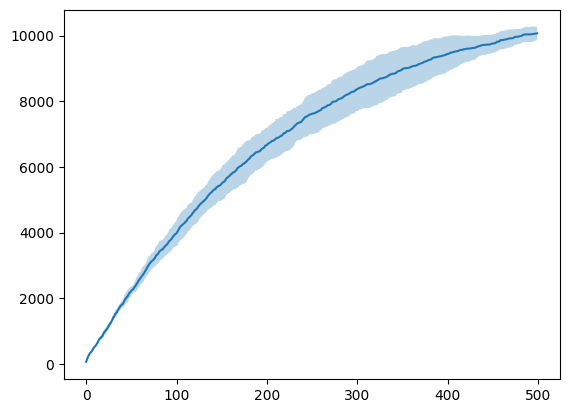

In [5]:
plt.figure()
x_plt = np.linspace(0, horizon-1, horizon, dtype=int)

for alg in algs:
    
    aux = np.zeros((num_trials, horizon))
    for i in range(num_trials):
        aux[i, :] = np.array(results_dict[i][alg]["res"]).sum(axis=1)
        
    results_alg = np.cumsum(aux, axis=1)
    results_mean = np.mean(results_alg, axis=0)
    results_std = 1.96 * results_alg.std(axis=0) / np.sqrt(num_trials)

    plt.plot(x_plt, results_mean[x_plt], label=alg)
    plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], results_mean[x_plt] + results_std[x_plt], alpha=0.3)